# Tarea 5
## Francisco Javier Peralta Ramírez

Implementar PCA (Eigenfaces) usando librerías de Python

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, NMF
from sklearn.datasets import fetch_mldata

In [2]:
# Load data
mnist = fetch_mldata('MNIST original')

/home/jperalta/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/jperalta/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


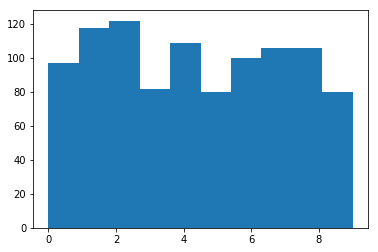

In [3]:
n_data = 1000
w, h = 28, 28
idx = np.random.randint(0,len(mnist.data), n_data) #seleccionamos indices aleatorios
X = mnist.data[idx]
Y = mnist.target[idx]
n_features = X.shape[1]
plt.hist(Y) #checamos que tan bien distribuidos estan
plt.show()

Graficamos las primeras diez imagenes

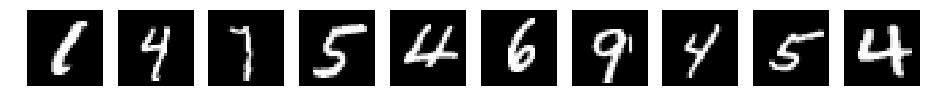

In [4]:
n_plots=10
f, ax = plt.subplots(1, n_plots, figsize=(16, 6))
for i in range(n_plots):
    ax[i].imshow(X[i].reshape(28, 28), cmap='gray')
    ax[i].axis('off')
plt.show()

In [5]:
%%time
n_components = 100
pca = PCA(100).fit(X)

CPU times: user 1.42 s, sys: 1.58 s, total: 3.01 s
Wall time: 278 ms


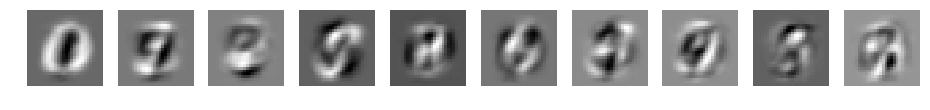

In [6]:
eigen_numbers = pca.components_.reshape(n_components, h, w)
f, ax = plt.subplots(1, n_plots, figsize=(16, 6))
for i in range(n_plots):
    ax[i].imshow(eigen_numbers[i], cmap='gray')
    ax[i].axis('off')
plt.show()

In [7]:
X_pca = pca.transform(X)

Graficamos la reconstrucción de las primeras diez imágenes con diferentes cantidades de componentes

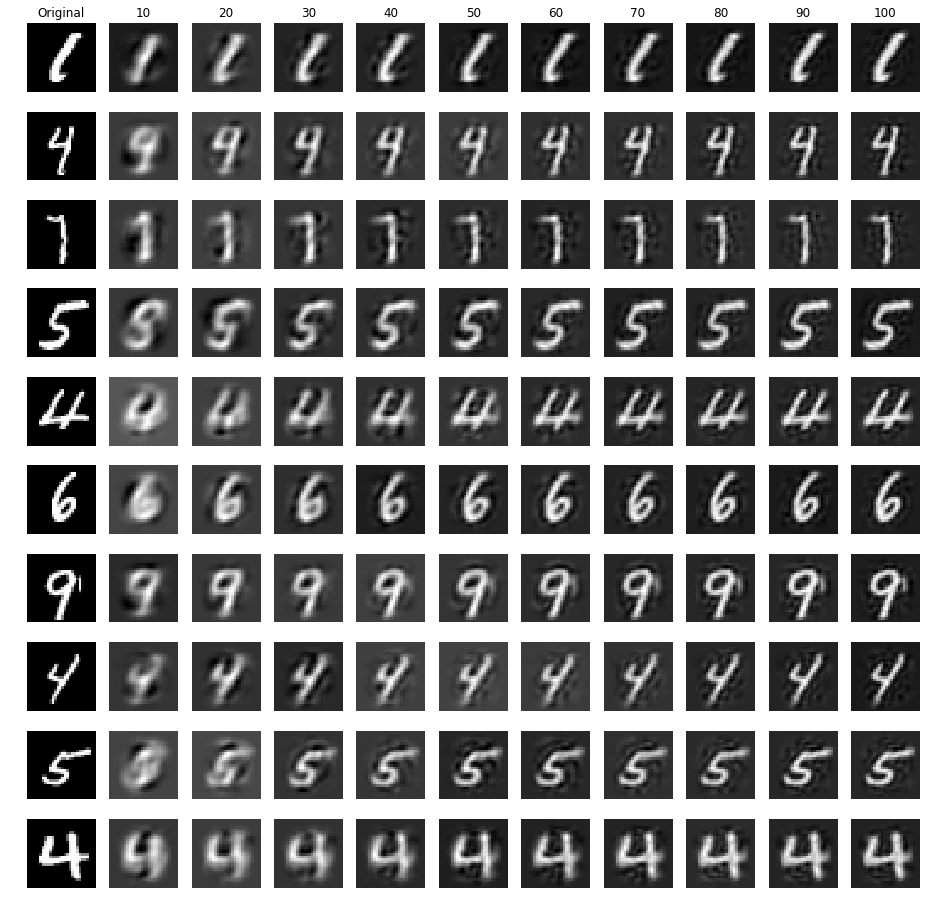

In [8]:
n_plots=11
f, ax = plt.subplots(10, n_plots, figsize=(16, 16))
ax[0][0].set_title("Original")
for k in range(10):
    img = (np.sum(X, axis=0)/1000).reshape(h, w) #iniciamos con imagen promedio
    ax[k][0].imshow(X[k].reshape(28,28), cmap='gray')
    ax[k][0].axis('off')
    for i in range(1, n_plots):
        for j in range(10):
            ij = (i-1) * 10 + j
            img += X_pca[k][ij] * eigen_numbers[ij] #sumamos cada eigen_numero pesado
        ax[k][i].axis('off')
        ax[k][i].imshow(img, cmap='gray')
        if(k == 0) : ax[k][i].set_title(i*10)

Podemos ver que Los resultados finales se parecen bastante al original, pero tienen muchos artefactos.

Ahora probamos con factorización no negativa de matrices usando la librería sklearn.

In [9]:
model = NMF(n_components=n_components)

In [46]:
%%time
W = model.fit_transform(X)
H = model.components_
print(np.linalg.norm(X - W @ H, ord='fro'))

20497.79289535595
CPU times: user 26.6 s, sys: 30.4 s, total: 57 s
Wall time: 4.79 s


Al igual que con PCA graficamos los resultados con diferentes cantidades de componentes

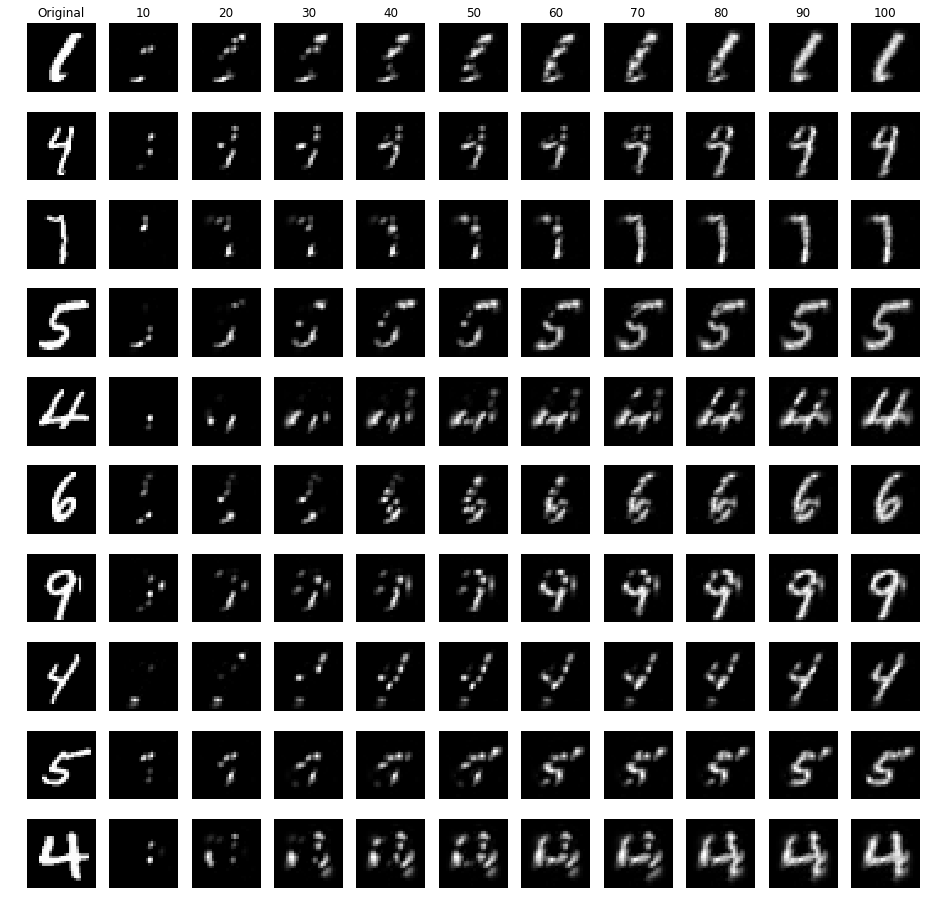

In [11]:
n_plots=11
f, ax = plt.subplots(10, n_plots, figsize=(16, 16))
ax[0][0].set_title("Original")
for k in range(10):
    ax[k][0].imshow(X[k].reshape(28,28), cmap='gray')
    ax[k][0].axis('off')
    for i in range(1, n_plots):
        n = i * 10
        img = (W[k][:n] @ H[:n]).reshape(28,28)
        ax[k][i].axis('off')
        ax[k][i].imshow(img, cmap='gray')
        if(k == 0) : ax[k][i].set_title(i*10)

Podemos ver que el resultado final, en todos lo casos, se ve mejor que con PCA, pero los resultados intemedios no son muy buenos. También odemos comparar los componenetes extraidos por ambos métodos, NMF y PCA

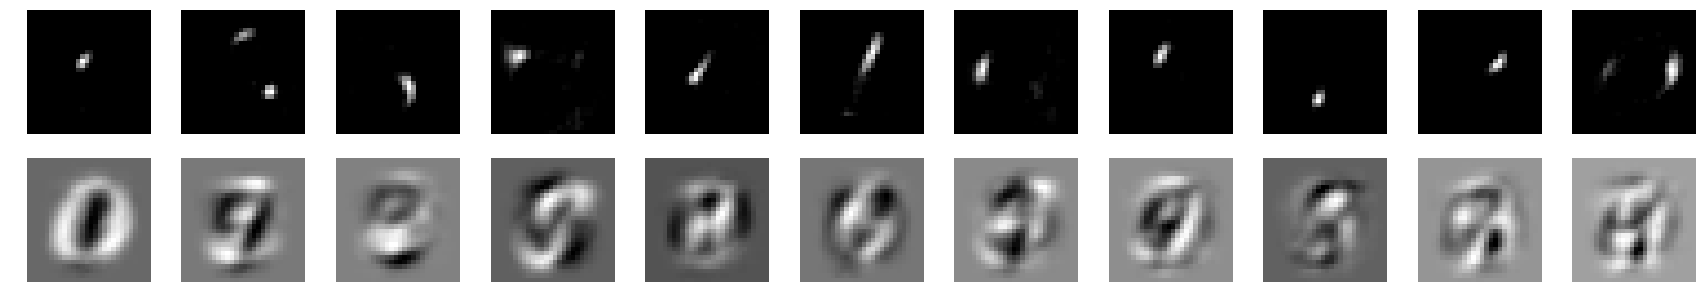

In [76]:
nmf_numbers = H.reshape(n_components, h, w)
f, ax = plt.subplots(2, n_plots, figsize=(30, 5))
for i in range(n_plots):
    ax[0][i].imshow(nmf_numbers[i], cmap='gray')
    ax[0][i].axis('off')
    ax[1][i].imshow(eigen_numbers[i], cmap='gray')
    ax[1][i].axis('off')
plt.show()

Observamos que NMF obtiene componentes que son más como partes de los números, mientras que PCA obtiene una mezcla de los números. Esto podría explicar los resultados vistos. Como PCA obtiene una combinación de los datos, pocos componentes logran reconstruir los datos originales de forma aceptable mientras que NMF con sus partes de los datos, no reconstrulle bien com pocos datos. 

Para programar el método de factorización no negativa de matrices, consideramos el problema

$$ min_{W, H} \frac{1}{2}||V - WH||_F^2 \,\,\,\, \text{s.a} \,\, W \geq 0 , H \geq 0 $$

Tenemos que los gradientes son:
$$ \nabla_Wf(W,H) = (WH-X)H^T \,\,\,\,\,\, \nabla_Hf(W,H)=W^T(WH-X) $$

In [64]:
def NMF_PG(X, nIter=500):
    W = np.random.rand(X.shape[0], n_components)
    H = np.random.rand(n_components, X.shape[1])
    for i in range(nIter):
        #optimizar W
        g_w = (W @ H - X) @ H.T #gradiente sobre w
        t_w = 1 / np.linalg.norm(H @ H.T, ord='fro') #tamaño de paso
    #     t_w = 0.0001
        W = W - t_w * g_w
        W[ W < 0] = 0
        #optimizar H
        g_h = W.T @ (W @ H - X) 
        t_h = 1 / np.linalg.norm(W @ W.T, ord='fro')
    #     t_h = 0.0001
        H = H - t_h * g_h
        H[ H < 0] = 0
    return W,H

In [65]:
%%time
W, H = NMF_PG(X)
print(np.linalg.norm(X - W @ H, ord='fro'))

23966.127867148043
CPU times: user 1min 29s, sys: 50.1 s, total: 2min 19s
Wall time: 11.8 s


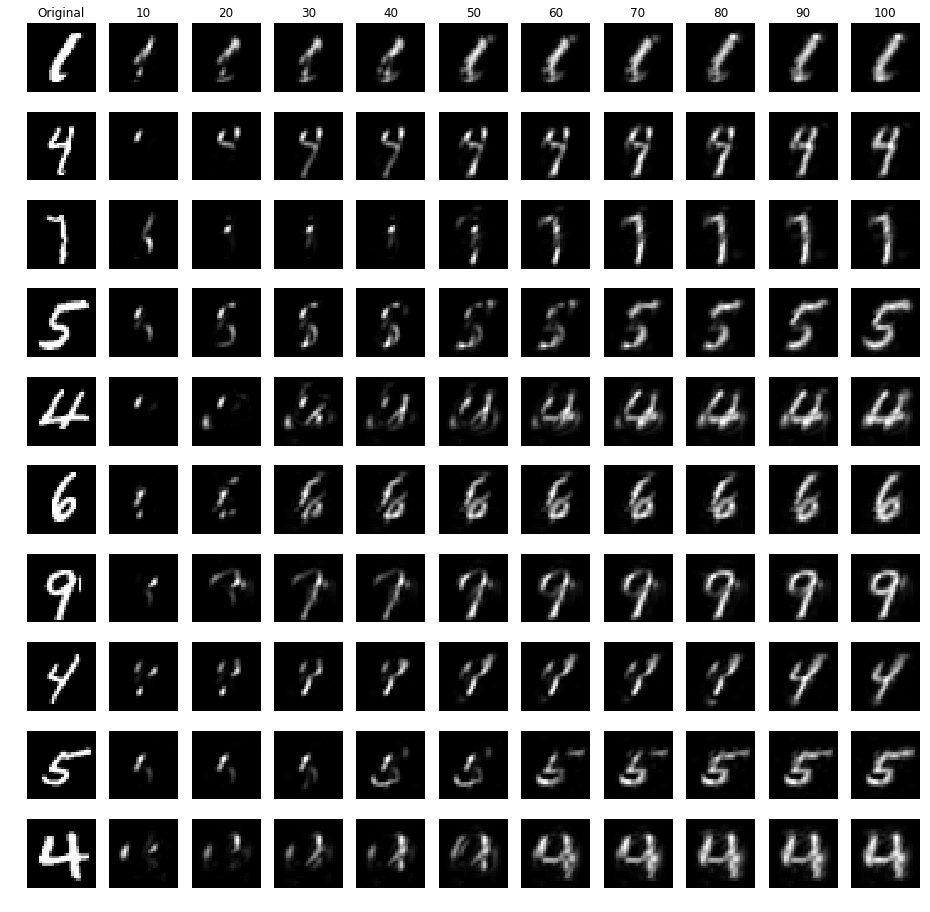

In [66]:
n_plots=11
f, ax = plt.subplots(10, n_plots, figsize=(16, 16))
ax[0][0].set_title("Original")
for k in range(10):
    ax[k][0].imshow(X[k].reshape(28,28), cmap='gray')
    ax[k][0].axis('off')
    for i in range(1, n_plots):
        n = i * 10
        img = (W[k][:n] @ H[:n]).reshape(28,28)
        ax[k][i].axis('off')
        ax[k][i].imshow(img, cmap='gray')
        if(k == 0) : ax[k][i].set_title(i*10)

Vemos resultados similares a los de sklear, pero con una calidad ligeramente peor, esto probablemente se debe a que sklearn usa un algoritmo más adecuado y otra función de costo (especificada en la documentación de sklearn)